In [52]:
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from Bio import pairwise2
from Bio.Align import substitution_matrices
from tqdm import trange

In [2]:
data = pd.read_csv('../../data/vdjdb.tsv', sep='\t')
data.head()

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...",2
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2


In [3]:
peptides = sorted(data['Epitope'].unique())
print(f'Num unique peptides = {len(peptides):,}')

Num unique peptides = 1,150


In [4]:
tcrs = sorted(data['CDR3'].unique())
print(f'Num unique TCRs = {len(tcrs):,}')

Num unique TCRs = 65,645


In [5]:
peptide_to_tcr = defaultdict(set)
tcr_to_peptide = defaultdict(set)

for peptide, tcr in zip(data['Epitope'], data['CDR3']):
    peptide_to_tcr[peptide].add(tcr)
    tcr_to_peptide[tcr].add(peptide)

In [6]:
tcr_counts_per_peptide = Counter([len(tcrs) for tcrs in peptide_to_tcr.values()])
tcr_counts_per_peptide.most_common()

[(2, 407),
 (4, 126),
 (1, 90),
 (3, 78),
 (6, 57),
 (5, 46),
 (7, 39),
 (8, 33),
 (9, 19),
 (10, 17),
 (12, 17),
 (14, 16),
 (11, 8),
 (13, 8),
 (15, 8),
 (22, 7),
 (18, 7),
 (19, 6),
 (21, 5),
 (30, 5),
 (16, 5),
 (25, 5),
 (20, 4),
 (32, 4),
 (17, 4),
 (63, 3),
 (31, 3),
 (58, 3),
 (29, 3),
 (28, 3),
 (69, 2),
 (61, 2),
 (53, 2),
 (108, 2),
 (60, 2),
 (254, 2),
 (26, 2),
 (148, 2),
 (51, 2),
 (66, 2),
 (264, 2),
 (50, 2),
 (54, 2),
 (240, 2),
 (76, 2),
 (44, 2),
 (36, 2),
 (48, 2),
 (91, 2),
 (35, 2),
 (146, 1),
 (303, 1),
 (64, 1),
 (136, 1),
 (82, 1),
 (1781, 1),
 (99, 1),
 (467, 1),
 (79, 1),
 (6916, 1),
 (102, 1),
 (47, 1),
 (71, 1),
 (536, 1),
 (6589, 1),
 (1274, 1),
 (597, 1),
 (38, 1),
 (118, 1),
 (386, 1),
 (168, 1),
 (161, 1),
 (170, 1),
 (106, 1),
 (1314, 1),
 (103, 1),
 (677, 1),
 (577, 1),
 (235, 1),
 (572, 1),
 (315, 1),
 (1494, 1),
 (3253, 1),
 (1088, 1),
 (201, 1),
 (159, 1),
 (163, 1),
 (165, 1),
 (189, 1),
 (96, 1),
 (117, 1),
 (33, 1),
 (508, 1),
 (73, 1),
 (24635,

In [7]:
peptide_counts_per_tcr = Counter([len(peptides) for peptides in tcr_to_peptide.values()])
peptide_counts_per_tcr.most_common()

[(1, 61513),
 (2, 3071),
 (3, 637),
 (4, 241),
 (5, 80),
 (6, 44),
 (7, 17),
 (8, 16),
 (9, 13),
 (12, 6),
 (10, 4),
 (15, 1),
 (14, 1),
 (11, 1)]

In [45]:
scoring = substitution_matrices.load("BLOSUM62")
gap_open = -5.0
gap_extend = -0.5
num_peptides = 100  # len(peptides)
scores = np.zeros((num_peptides, num_peptides))

for i in trange(num_peptides):
    for j in range(i + 1, num_peptides):
        scores[i, j] = pairwise2.align.globalds(peptides[i], peptides[j], scoring, gap_open, gap_extend, score_only=True)

100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


In [46]:
scores_flat = [scores[i, j] for i in range(num_peptides) for j in range(i + 1, num_peptides)]

(array([  2.,   0.,   2.,   2.,   9.,  15.,  17.,  29.,  51.,  47.,  97.,
        129.,  59., 191., 257., 202., 302., 336., 109., 358., 346., 243.,
        347., 278.,  70., 268., 229., 196., 141., 123.,  99.,  25.,  85.,
         74.,  37.,  35.,  31.,   4.,  29.,  14.,  11.,  12.,   5.,   0.,
          4.,   2.,   4.,   2.,   0.,   0.,   3.,   0.,   1.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,
          1.,   1.,   0.,   0.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-18.  , -17.16, -16.32, -15.48, -14.64, -13.8 , -12.96, -12.12,
        -11.28, -10.44,  -9.6 ,  -8.76,  -7.92,  -7.08,  -6.24,  -5.4 ,
         -4.56,  -3.72,  -2.88,  -2.04,  -1.2 ,  -0.36,   0.48,   1.32,
          2.16,   3.  ,   3.84,   4.68,   5.52,   6.36,   7.2 ,   8.04,
          8.88,   9.72,  10.56

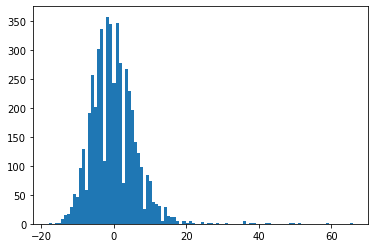

In [47]:
plt.hist(scores_flat, bins=100)

In [50]:
mean = np.mean(scores_flat)
std = np.std(scores_flat)
print(f'Scores = {mean:.2f} +/- {std:.2f}')

threshold = mean + 3 * std
print(f'Threshold = mean + 3 * std = {threshold}')

I, J = np.where(scores > threshold)

Scores = -0.06 +/- 6.29
Threshold = mean + 3 * std = 18.80706554894174


In [51]:
for i, j in zip(I, J):
    print(peptides[i], peptides[j])

AAGIGILTV ALGIGILTV
AALALLLLDRLNQLE ALALLLLDR
ADGLAYFRSSFKGG ADLIAYLEQATKG
ADGLAYFRSSFKGG ADLIAYLKQATKG
ADGLAYFRSSFKGG ADSLSFFSSSIKRGGGSLVP
ADGLAYFRSSFKGG ANGVAFFLTPFKA
ADLIAYLEQATKG ADLIAYLKQATKG
ALDPHSGHFV ALSKGVHFV
ALGIGILTV CLGGLLTMV
ALLLQLFTL AMQTMLFTM
ALNLGETFV ALSKGVHFV
ALSPVIPHI ALTPVVVTL
ALTPVVVTL CLTPVYSFL
ALWGFFPVL ALWGPDPAAA
ALWGFFPVL ALYGFVPVL
ALWGPDPAAA AQWGPDPAAA
AMDEFIEQY AMDEFIERY
APLLSAGIF APLLSAGVF
APMPMPELPYP APQPELPYPQPG
APMPMPELPYP APQPELPYPQPGS
APMPMPELPYP AVVQSELPYPEGS
APQPELPYPQPG APQPELPYPQPGS
APQPELPYPQPG AVVQSELPYPEGS
APQPELPYPQPGS AVVQSELPYPEGS
APRGPHGGAASGL APRITFGGL
APRITFGGL APTKVTFGV
ATDALMTGF ATDALMTGY
ATSRMLSYY ATSRTLSYY
AVGSYVYSV CLGSLIYST
CFAYYFMRF CLAYYFMRF
CLEASFNYL CLTPVYSFL
CLGGLLTMV CLGSLIYST
CLNEYHLFL CLTPVYSFL
CPACHNSEV CPACYNSEV


In [ ]:
# equivalent_aas = [set(aas) for aas in ['GA', 'VLI', 'FYW', 'ST', 'KR', 'DE', 'NQ']]
# equivalent_aa_map = {}

# for equivalence_class in equivalent_aas:
#     for aa in equivalence_class:
#         equivalent_aa_map[aa] = equivalence_class

# def compute_similarity(pep_1: str, pep_2: str) -> float:
#     num_equivalent = sum()

In [39]:
# num_peptides = 100  # len(peptides)
# similarities = np.zeros(num_peptides)

# for i in trange(num_peptides):
#     for j in range(i + 1, num_peptides):
#         similarities[i, j] = compute_similarity(peptides[i], peptides[j])

In [64]:
graph = nx.Graph()
graph.add_nodes_from(peptides[:num_peptides])
for i, j in zip(I, J):
    graph.add_edge(peptides[i], peptides[j])

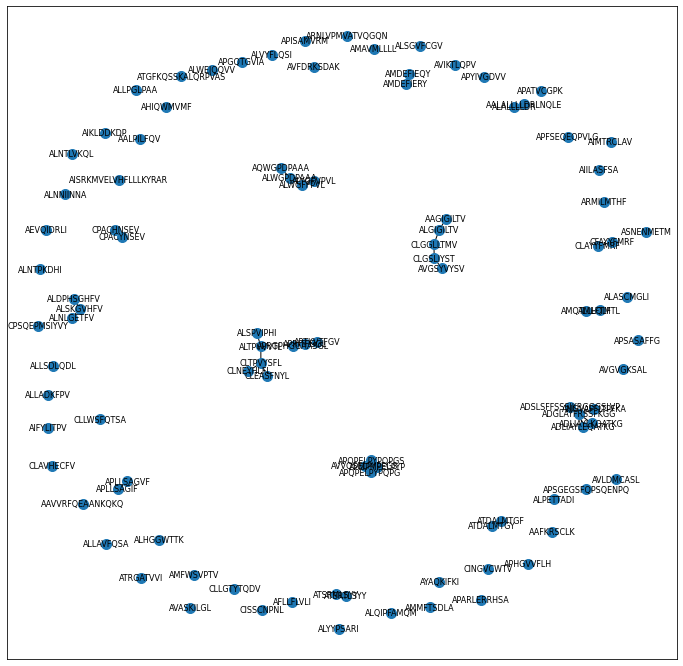

In [68]:
plt.figure(figsize=(12,12)) 
nx.draw_networkx(graph, node_size=100, font_size=8)

In [72]:
components = [sorted(component) for component in sorted(nx.connected_components(graph), key=len, reverse=True) if len(component) > 1]
components

[['AAGIGILTV', 'ALGIGILTV', 'AVGSYVYSV', 'CLGGLLTMV', 'CLGSLIYST'],
 ['ADGLAYFRSSFKGG',
  'ADLIAYLEQATKG',
  'ADLIAYLKQATKG',
  'ADSLSFFSSSIKRGGGSLVP',
  'ANGVAFFLTPFKA'],
 ['ALSPVIPHI', 'ALTPVVVTL', 'CLEASFNYL', 'CLNEYHLFL', 'CLTPVYSFL'],
 ['ALWGFFPVL', 'ALWGPDPAAA', 'ALYGFVPVL', 'AQWGPDPAAA'],
 ['APMPMPELPYP', 'APQPELPYPQPG', 'APQPELPYPQPGS', 'AVVQSELPYPEGS'],
 ['ALDPHSGHFV', 'ALNLGETFV', 'ALSKGVHFV'],
 ['APRGPHGGAASGL', 'APRITFGGL', 'APTKVTFGV'],
 ['AALALLLLDRLNQLE', 'ALALLLLDR'],
 ['ALLLQLFTL', 'AMQTMLFTM'],
 ['AMDEFIEQY', 'AMDEFIERY'],
 ['APLLSAGIF', 'APLLSAGVF'],
 ['ATDALMTGF', 'ATDALMTGY'],
 ['ATSRMLSYY', 'ATSRTLSYY'],
 ['CFAYYFMRF', 'CLAYYFMRF'],
 ['CPACHNSEV', 'CPACYNSEV']]

In [81]:
for index, component in enumerate(components):

    tcr_to_count = defaultdict(int)

    for peptide in component:
        for tcr in peptide_to_tcr[peptide]:
            tcr_to_count[tcr] += 1

    num_shared_tcrs = sum(count > 1 for count in tcr_to_count.values())

    if num_shared_tcrs > 0:
        print(f'Component {index}\n')
        print(f'Num peptides = {len(component):,}')
        print(f'Num shared TCRs = {num_shared_tcrs:,}\n')

        for tcr, count in tcr_to_count.items():
            if count > 1:
                print(f'{tcr}: {count:,}')

        print('\n' + '-' * 20 + '\n')

Component 1

Num peptides = 5
Num shared TCRs = 5

CASSLNNANSDYTF: 4
CAAEASNTNKVVF: 2
CAAEPSSGQKLVF: 2
CASSLNWSQDTQYF: 2
CAALRATGGNNKLTF: 2

--------------------

Component 3

Num peptides = 4
Num shared TCRs = 2

CAMRGDSSYKLIF: 2
CASSLWEKLAKNIQYF: 2

--------------------

Component 4

Num peptides = 4
Num shared TCRs = 2

CASSFRALAADTQYF: 2
CIAFQGAQKLVF: 2

--------------------

Component 11

Num peptides = 2
Num shared TCRs = 5

CASRTGISNTGELFF: 2
CASRGDTFYEQYF: 2
CASSLVGQLDEQYF: 2
CASSGTRQISGTEAFF: 2
CASSLSGQLDTQYF: 2

--------------------

